# Portfolio Management Project


Author : 
Audric Dongfack (dongfackaudric@gmail.com)

In [1]:
#import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats 
from pandas_datareader import data 
from datetime import datetime
from scipy.optimize import minimize

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import risk_kit as erk

In [4]:
# using seaborn style (type plt.style.available to see available styles)
plt.style.use("seaborn-dark")

## Modern portfolio theory (MPT)

The **Modern portfolio theory (MPT)** is a mathematical framework **for assembling a portfolio of assets such that the expected return is maximized for a given level of volatility**. It is a formalization of **diversification in investing**, i.e., the idea that owning different kinds of financial assets is less risky than owning only one assets. 

### Efficient Frontiers 

In the MPT, the **efficient frontier** is an a curve which occupies the **efficient** part of the **volatility-return plane**. 
Formally, it is the set of portfolios that can be constructed with the given input assets 
that have the maximum expected returns for a fixed level of volatility and, in turn, 
the lowest volatilities for a fixed level of expected return. The efficient frontier was first formulated by **Harry Markowitz** (1952).

We have to construct a portfolio of several assets and **we want to find the optimal percentages of investment to be allocated in these assets** so that, for example, the total (expected) return of such a portfolio is maximixed for a given level of volatility. 

Hence, suppose that **we have $N > 1$ assets**, and we decide to invest all of our capital in them. Let $\mathbf{w}:=(w_1,\dots,w_N)^T$, with $w_i\in (0,1)$ for all $i=1,\dots,N$, 
be the percentages of investment our portfolio, i.e., $w_i$ is the proportion of investiment in asset $i$. 
We will call the quantities $w_i$ as the **weights**. 

Since we invest all of our capital, there holds $\sum_{i=1}^N w_i = 1$ (this is a **long-only** strategy).

Let $R_i$ and $R_p$ be the return of asset $i$ and the total return of the portfolio, respectively. 
Likewise, let $\sigma_i$ and $\sigma_p$ be the volatility of asset $i$ and the volatility of the portfolio, respectively. 


### Return of a portfolio
The **total return of the porfolio** is going to be a simple weigthed sum of the (total) returns of single assets, i.e.,
$$
R_p = \sum_{i=1}^N w_i R_i = \mathbf{w}^T \mathbf{R},
$$
where $\mathbf{R} := (R_1,\dots,R_N)^T$. 
Note that if we have a dataset of **past returns**, the total return $R_p$ is computed as above using the returns of the past data. On the other hand, if we are going to compute invest now, we do not have a series of true (past) return, but we instead would have **expected returns**. Hence, in this case we would have the maean value $\mathbb{E}$ in the formula above. 


### Volatility of a portfolio
The **volatility of the porfolio** is computed as the (square root of the) variance of the weigthed sum of the returns of single assets. 

Let us make and axample with only two assets. We have $w_1$ and $w_2$ and two assets whose returns are $R_1$ and $R_2$. We have:
$$
\sigma_p^2 =   \text{Var}(w_1 R_1 + w_2 R_2) = 
w_1^2 \text{Var}(R_1) + w_2^2\text{Var}(R_2) + 2w_1 w_2\text{Cov}(R_1,R_2) =
w_1^2 \sigma_1^2 + w_2^2\sigma_2^2 + 2w_1 w_2\text{Cov}(R_1,R_2), 
$$
where 
$$
\text{Cov}(R_1,R_2) := \mathbb{E}[(R_i-\mu_i)(R_j - \mu_j)], 
$$
is the **covariance** between asset $i$ and $j$ and where $\mu_i$ and $\mu_j$ denote 
the mean returns of assets $i$ and $j$, respectively. In particular, if we let 
$$
\rho_{ij} := \frac{\text{Cov}(R_i,R_j)}{\sigma_i \sigma_j} = \frac{\text{Cov}(i,j)}{\sigma_1 \sigma_2}, 
$$
denote the **correlation coefficient** between assets $i$ and asset $j$, then the volatility of a $2$ assets portfolio becomes:
$$
\sigma_p = 
\sqrt{ w_i^2 \sigma_1^2 + w_2^2 \sigma_2^2 + 2w_1 w_2 \sigma_1 \sigma_2 \rho_{ij} }. 
$$
Note that we can write in compact form the such volatility using matrix notation. That is:
$$
\sigma_p = 
\sqrt{
(w_i, w_2)\, 
\begin{pmatrix}
\sigma^2_1 & \sigma_1 \sigma_2 \rho_{12} \\
\sigma_1 \sigma_2 \rho_{21} & \sigma^2_2
\end{pmatrix}
\begin{pmatrix}
w_1 \\
w_2 
\end{pmatrix}
}
=
\sqrt{
\mathbf{w}^T \Sigma \mathbf{w}
}
\quad\text{and}\quad
\Sigma := 
\begin{pmatrix}
\sigma^2_1 & \sigma_1 \sigma_2 \rho_{12} \\
\sigma_1 \sigma_2 \rho_{21} & \sigma^2_2
\end{pmatrix},
$$
where $\Sigma$ is the symmetric square **covariance matrix**.


Now, in case of $N$ assets, let again $\Sigma$ be the $N\times N$ covariance matrix, $\Sigma = [c_{ij}]$, 
where each element $c_{ij} := \sigma_i \sigma_j \rho_{ij}$ ($i,j=1,\dots,N$) denote the **covariance** between assets $i$ 
and asset $j$, with $\sigma_i$, $\sigma_j$, and $\rho_{ij}$ being the volatility 
and the correlation coefficient of assets $i$ and $j$, respectively. 
If $i=j$, $c_{ii}=\sigma_i^2$ is simply the variance of asset $i$ (**diagonal entries are the variances**).

The volatility of the portfolio is then given by:
$$
\sigma_p = \sqrt{ \mathbf{w}^T \Sigma \mathbf{w} }.
$$


### Construction of our portfolio: CAC stocks
Now we will get the timeseries of our 12 company economy stocks and we will  construct our portfolio in an efficient way.
two things to note:

- As our universe only contains cac companies, we can easily download the data directly on 'yahoo finance'
- We are used Historical data from 31/01/2006 to 29/01/2016.


In [7]:
tickers  = ['BN.PA','CA.PA','KER.PA','MC.PA','OR.PA','SAN.PA','VIV.PA','ENGI.PA','SW.PA','VIE.PA','CAP.PA','ATO.PA']
n_assets = len(tickers) 

stocks = pd.DataFrame()
for stock_name in tickers:
    # daily data
    stocks[stock_name] = data.DataReader(stock_name, data_source="yahoo", 
                                         start=datetime(2006,1,31), end=datetime(2016,1,29))["Adj Close"]    

In [8]:
stocks.tail()

,BN.PA,CA.PA,KER.PA,MC.PA,OR.PA,SAN.PA,VIV.PA,ENGI.PA,SW.PA,VIE.PA,CAP.PA,ATO.PA
Date,,,,,,,,,,,,
2016-01-25,53.959095,22.220619,130.139511,132.994186,141.626938,62.039093,16.556992,11.392614,76.735802,18.072645,79.049232,50.801075
2016-01-26,54.147385,22.211735,131.299042,133.918411,142.045975,62.437038,16.666725,11.557374,76.954193,18.186813,79.180435,50.660549
2016-01-27,55.088844,22.456064,132.157364,135.027481,143.628906,62.664436,16.957937,11.734192,77.749161,18.410925,78.796211,50.962761
2016-01-28,54.945385,22.478275,129.967697,132.809357,142.278748,60.934597,16.894630,11.698026,77.417198,18.262926,76.125305,49.824242
2016-01-29,56.891071,23.304552,133.145004,136.968323,146.701691,62.169037,16.907293,11.810545,78.762520,18.770348,78.796211,51.124348


In [29]:
#we rename  the columns 
stocks.columns=['Danone','Carrefour','Kering','Lvmh','Oreal','Sanofi','Vivendi','Engie','Sodexo','Veolia','Capgemini','Atos']

In [30]:
#we compute the daily returns 
daily_rets = erk.compute_returns(stocks)
daily_rets.tail()

,Danone,Carrefour,Kering,Lvmh,Oreal,Sanofi,Vivendi,Engie,Sodexo,Veolia,Capgemini,Atos
Date,,,,,,,,,,,,
2016-01-25,0.009562,-0.011462,-0.010773,0.005239,0.010631,0.002494,0.002556,-0.016990,0.000570,0.005647,0.015776,-0.002898
2016-01-26,0.003489,-0.000400,0.008910,0.006949,0.002959,0.006414,0.006628,0.014462,0.002846,0.006317,0.001660,-0.002766
2016-01-27,0.017387,0.011000,0.006537,0.008282,0.011144,0.003642,0.017473,0.015299,0.010330,0.012323,-0.004853,0.005965
2016-01-28,-0.002604,0.000989,-0.016569,-0.016427,-0.009400,-0.027605,-0.003733,-0.003082,-0.004270,-0.008039,-0.033896,-0.022340
2016-01-29,0.035411,0.036759,0.024447,0.031315,0.031086,0.020258,0.000750,0.009619,0.017378,0.027784,0.035086,0.026094


In [31]:
# we compute the mean daily returns and the covariance of daily returns of the our assets
mean_rets = daily_rets.mean()
std_rets  = daily_rets.std()
cov_rets  = daily_rets.cov()
cov_rets

,Danone,Carrefour,Kering,Lvmh,Oreal,Sanofi,Vivendi,Engie,Sodexo,Veolia,Capgemini,Atos
Danone,0.000218,0.000155,0.000148,0.000156,0.000140,0.000129,0.000113,0.000142,0.000098,0.000120,0.000145,0.000112
Carrefour,0.000155,0.000375,0.000214,0.000198,0.000162,0.000161,0.000170,0.000194,0.000128,0.000191,0.000206,0.000165
Kering,0.000148,0.000214,0.000438,0.000283,0.000176,0.000152,0.000169,0.000179,0.000173,0.000202,0.000261,0.000218
Lvmh,0.000156,0.000198,0.000283,0.000359,0.000188,0.000158,0.000174,0.000191,0.000153,0.000200,0.000245,0.000198
Oreal,0.000140,0.000162,0.000176,0.000188,0.000238,0.000135,0.000127,0.000158,0.000112,0.000140,0.000168,0.000135
Sanofi,0.000129,0.000161,0.000152,0.000158,0.000135,0.000265,0.000136,0.000161,0.000102,0.000135,0.000153,0.000128
Vivendi,0.000113,0.000170,0.000169,0.000174,0.000127,0.000136,0.000259,0.000177,0.000109,0.000162,0.000182,0.000143
Engie,0.000142,0.000194,0.000179,0.000191,0.000158,0.000161,0.000177,0.000372,0.000122,0.000226,0.000212,0.000161
Sodexo,0.000098,0.000128,0.000173,0.000153,0.000112,0.000102,0.000109,0.000122,0.000238,0.000117,0.000172,0.000141
Veolia,0.000120,0.000191,0.000202,0.000200,0.000140,0.000135,0.000162,0.000226,0.000117,0.000468,0.000218,0.000181


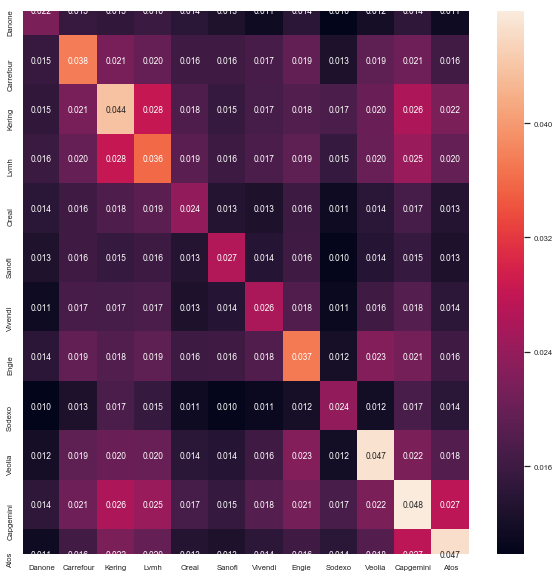

In [33]:
#representation of the cov matrix 
import seaborn as sn
sn.set()
sn.set(font_scale=0.7)
sn.heatmap(cov_rets*100,annot=True,fmt=".3f")
sn.set(rc={'figure.figsize':(10,10)})
plt.show()

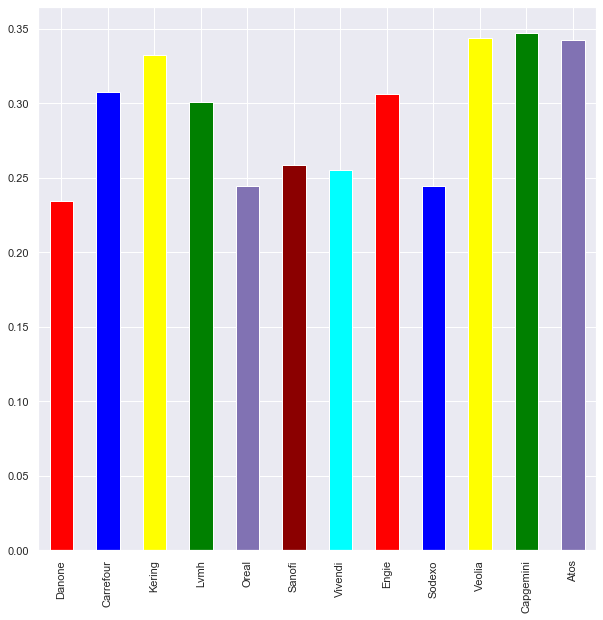

In [43]:
#Annual risk of individual asset
annual_std_rets= std_rets * np.sqrt(252)
annual_std_rets.plot.bar(color=['red','blue','yellow','green','m','darkred','cyan'])

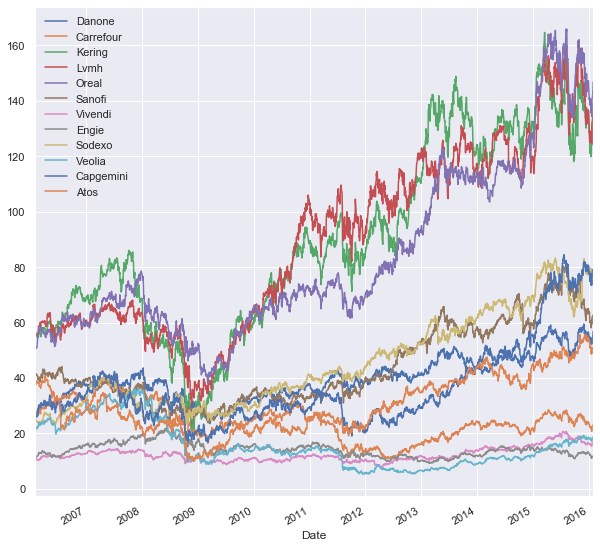

In [44]:
#process of each action

stocks.plot()


Now we simulate $4000$ portfolios with weights allocated to the stocks above:

In [45]:
#we will suppose that the risk free asset equal to 0
periods_per_year = 252
num_portfolios   = 4000
portfolios       = pd.DataFrame(columns=["return","volatility","sharpe ratio","w1","w2","w3","w4","w5","w6","w7","w8","w9","w10","w11","w12"])
risk_free_rate   = 0 

In [46]:
for i in range(num_portfolios):
    # select random weights
    weights = np.random.random(n_assets)
    # and rescale them to sum to 1
    weights /= np.sum(weights)
    
    # annualized portfolio returns
    ann_rets      = erk.annualize_rets(daily_rets, periods_per_year)
    portfolio_ret = erk.portfolio_return(weights, ann_rets)        

    # annualized portfolio volatility
    portfolio_vol = erk.portfolio_volatility(weights, cov_rets)
    portfolio_vol = erk.annualize_vol(portfolio_vol, periods_per_year)

    # annualized portfolio sharpe ratio
    portfolio_spr = erk.sharpe_ratio(portfolio_ret, risk_free_rate, periods_per_year, v=portfolio_vol)
    
    # create dataframe   
    portfolios = portfolios.append( {"return":portfolio_ret, 
                                     "volatility":portfolio_vol, 
                                     "sharpe ratio":portfolio_spr, 
                                     "w1": weights[0], "w2": weights[1], "w3": weights[2],"w4":weights[3],"w5":weights[4],"w6":weights[5],"w7":weights[6],"w8":weights[7],"w9":weights[8],"w10":weights[9],"w11":weights[10],"w12":weights[1]}, 
                                     ignore_index=True)

Now we create a scatter plot coloured by sharpe ratios of the portfolios generated above and we also plot the efficient frontier:

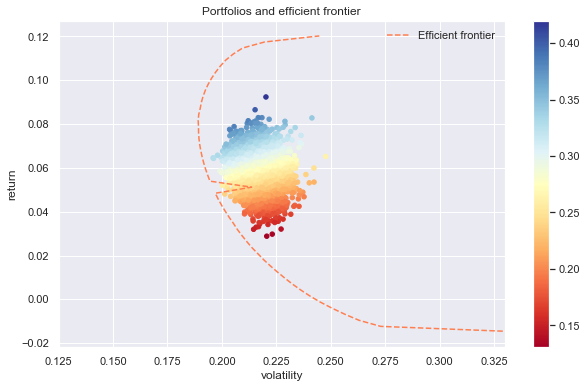

In [47]:
fig, ax = plt.subplots(1,1, figsize=(10,6)) 

im = ax.scatter(portfolios["volatility"], portfolios["return"], c=portfolios["sharpe ratio"], s=20, edgecolor=None, cmap='RdYlBu')
ax.set_title("Portfolios and efficient frontier")
ax.set_xlabel("volatility")
ax.set_ylabel("return")
ax.grid()

# Draw the efficient frontier
df = erk.efficient_frontier(50, daily_rets, cov_rets, periods_per_year)
df.plot.line(x="volatility", y="return", style="--", color="coral", ax=ax, grid=True, label="Efficient frontier")
ax.set_xlim([0.125,0.33])

fig.colorbar(im, ax=ax)
plt.show()


We can now plot, our  **two important** portfolios:

1. the **portfolio with the Global Minimum Volatility (GMV)**, i.e., the global minimum variance portfolio
2. the **portfolio with the Maximum Sharpe Ratio (MSR)**. // what we will choose

To do that we use a bibliotheque above and recover the corresponding weights that have been stored.

In [48]:
# find the portfolio with lowest volatility 
low_vol_portfolio = portfolios.iloc[ portfolios['volatility'].idxmin() ]
print("Global Minimum Volatility portfolio:")
print("- return      : {:.2f}%".format(low_vol_portfolio[0]*100) )
print("- volatility  : {:.2f}%".format(low_vol_portfolio[1]*100) )
print("- sharpe ratio: {:.2f}".format(low_vol_portfolio[2]) )

# find the portfolio with highest sharpe ratio
high_sharpe_portfolio = portfolios.iloc[ portfolios['sharpe ratio'].idxmax() ]
print("\Maximum Sharpe Ratio portfolio:")
print("- return      : {:.2f}%".format(high_sharpe_portfolio[0]*100) )
print("- volatility  : {:.2f}%".format(high_sharpe_portfolio[1]*100) )
print("- sharpe ratio: {:.2f}".format(high_sharpe_portfolio[2]) )

Global Minimum Volatility portfolio:
- return      : 6.46%
- volatility  : 19.60%
- sharpe ratio: 0.33
\Maximum Sharpe Ratio portfolio:
- return      : 9.24%
- volatility  : 22.02%
- sharpe ratio: 0.42


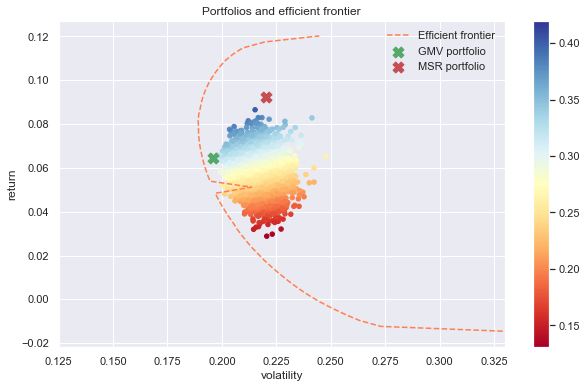

In [49]:
fig, ax = plt.subplots(1,1, figsize=(10,6)) 

im = ax.scatter(portfolios["volatility"], portfolios["return"], c=portfolios["sharpe ratio"], s=20, edgecolor=None, label=None, cmap='RdYlBu')
ax.set_title("Portfolios and efficient frontier")
ax.set_xlabel("volatility")
ax.set_ylabel("return")
ax.grid()

# Draw the efficient frontier
df.plot.line(x="volatility", y="return", style="--", color="coral", ax=ax, grid=True, label="Efficient frontier")

ax.scatter(low_vol_portfolio[1],     low_vol_portfolio[0],     marker="X", color='g', s=120, label="GMV portfolio")
ax.scatter(high_sharpe_portfolio[1], high_sharpe_portfolio[0], marker="X", color='r', s=120, label="MSR portfolio")

ax.set_xlim([0.125,0.33])
ax.legend()

fig.colorbar(im, ax=ax)
plt.show()

In [79]:
high_sharpe_portfolio[3:]

w1     0.160947
w2     0.004747
w3     0.164780
w4     0.178637
w5     0.090378
w6     0.027934
w7     0.035345
w8     0.011751
w9     0.184513
w10    0.003752
w11    0.120477
w12    0.004747
Name: 2030, dtype: float64

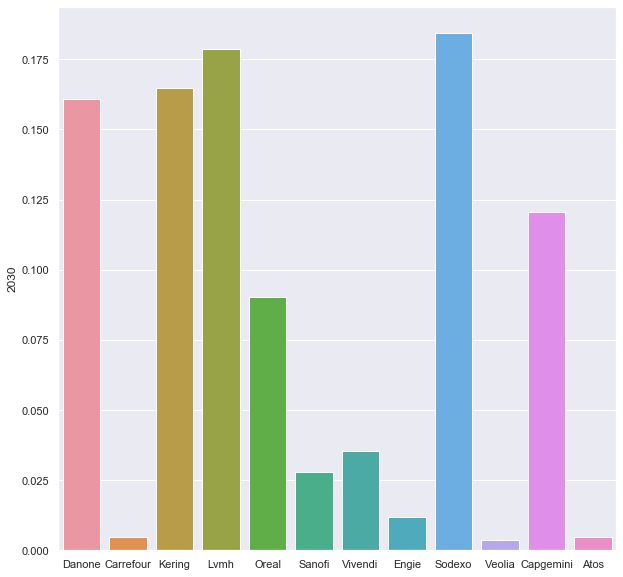

In [76]:
#We plot the weights of the portfolio which maximun sharp 
#high_sharpe_portfolio[3:].plot.bar()
column = ['Danone','Carrefour','Kering','Lvmh','Oreal','Sanofi','Vivendi','Engie','Sodexo','Veolia','Capgemini','Atos']
sn.barplot(column,high_sharpe_portfolio[3:])

#Another

Let us define the following function which we are going to use above:

In [80]:
def get_portfolio_features(weights, rets, covmat, risk_free_rate, periods_per_year):
    # portfolio volatility
    vol = erk.portfolio_volatility(weights, covmat)
    vol = erk.annualize_vol(vol, periods_per_year)

    # portfolio return
    ret = erk.portfolio_return(weights, rets)

    # portfolio sharpe ratio
    shp = erk.sharpe_ratio(ret, risk_free_rate, periods_per_year, v=vol)

    print("Portfolio return:       {:.2f}%" .format(ret*100))
    print("Portfolio volatility:   {:.2f}%" .format(vol*100))
    print("Portfolio sharpe ratio: {:.2f}" .format(shp))
    
    return ret, vol, shp

### Finding the optimal portfolios: maximizing the sharpe ratio - Second Approach  
Here, note that scipy offers a **minimize** method, but no a **maximize** a method, and we may then conclude 
that we are not able to find such a portfolio by solving an optimization problem. 
However, **the maximization of the sharpe ratio is nothing but the minimization of the negative sharpe ratio**. 
That is, we have 
$$
\text{minimize} \;\; -  \frac{R_p - r_f}{\sigma_p}  
$$
subject to 
$$
\begin{cases}
\mathbf{w}^T \mathbf{1} = 1, \\
0 \leq \mathbf{w} \leq 1.
\end{cases}
$$
$\textbf{important} : r_f = 0$ for us
\newline

Let us use our minimizer:

In [87]:
optimal_weights = erk.maximize_shape_ratio(ann_rets, cov_rets, risk_free_rate, periods_per_year)
print("optimal weights:")
print("  Danone: {:.2f}%".format(optimal_weights[0]*100))
print("  Carrefour:   {:.2f}%".format(optimal_weights[1]*100))
print("  Kering: {:.2f}%".format(optimal_weights[2]*100))
print("  Lvmh: {:.2f}%".format(optimal_weights[3]*100))
print("  Oreal: {:.2f}%".format(optimal_weights[4]*100))
print("  Sanofi: {:.2f}%".format(optimal_weights[5]*100))
print("  Vivendi: {:.2f}%".format(optimal_weights[6]*100))
print("  Engie: {:.2f}%".format(optimal_weights[7]*100))
print("  Sodexo: {:.2f}%".format(optimal_weights[8]*100))
print("  Veolia: {:.2f}%".format(optimal_weights[9]*100))
print("  Capgemini: {:.2f}%".format(optimal_weights[10]*100))
print("  Atos: {:.2f}%".format(optimal_weights[11]*100))

optimal weights:
  Danone: 0.00%
  Carrefour:   0.00%
  Kering: 0.00%
  Lvmh: 0.00%
  Oreal: 42.84%
  Sanofi: 0.00%
  Vivendi: 0.00%
  Engie: 0.00%
  Sodexo: 56.68%
  Veolia: 0.00%
  Capgemini: 0.48%
  Atos: 0.00%


Portfolio return:       11.53%
Portfolio volatility:   21.05%
Portfolio sharpe ratio: 0.55


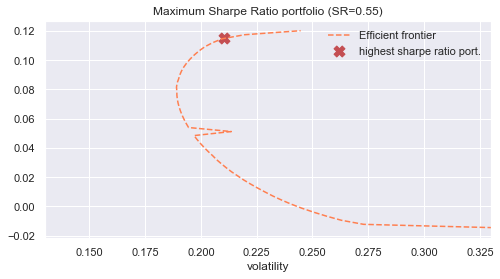

In [88]:
ret, vol, shp = get_portfolio_features(optimal_weights, ann_rets, cov_rets, risk_free_rate, periods_per_year)

# Draw the efficient frontier
fig, ax = plt.subplots(1,1, figsize=(8,4)) 
df = erk.efficient_frontier(50, daily_rets, cov_rets, periods_per_year)
df.plot.line(x="volatility", y="return", style="--", color="coral", ax=ax, grid=True, label="Efficient frontier")
ax.scatter(vol, ret,  marker="X", color='r', s=120, label="highest sharpe ratio port.")
ax.set_xlim([0.13,0.33])
ax.legend()
ax.set_title("Maximum Sharpe Ratio portfolio (SR={:.2f})".format(shp))
plt.show()

and let us see how these numbers differ from those obtained from the Monte Carlo simulation:

In [89]:
print("MSR portfolio:\n")
print("- Monte carlo:")
print("  return:       {:.2f}%" .format(high_sharpe_portfolio[0]*100))
print("  volatility:   {:.2f}%" .format(high_sharpe_portfolio[1]*100))
print("  sharpe ratio: {:.2f}" .format(high_sharpe_portfolio[2]))
print("\n- Minimization problem:")
print("  return:       {:.2f}%" .format(ret*100))
print("  volatility:   {:.2f}%" .format(vol*100))
print("  sharpe ratio: {:.2f}" .format(shp))

MSR portfolio:

- Monte carlo:
  return:       9.24%
  volatility:   22.02%
  sharpe ratio: 0.42

- Minimization problem:
  return:       11.53%
  volatility:   21.05%
  sharpe ratio: 0.55


# Portfolio Performance analysis

In [98]:
tickerscomp  = ['OR.PA','SW.PA','CAP.PA','^FCHI']
n_assets = len(tickerscomp) 

stocksnew = pd.DataFrame()
for stock_name in tickerscomp:
    # daily data
    stocksnew[stock_name] = data.DataReader(stock_name, data_source="yahoo", 
                                         start=datetime(2016,1,29), end=datetime(2017,11,30))["Adj Close"]  

In [99]:
stocksnew.tail()

,OR.PA,SW.PA,CAP.PA,^FCHI
Date,,,,
2017-11-27,179.538086,98.887184,97.633980,5360.089844
2017-11-28,180.745636,100.170837,98.069633,5390.479980
2017-11-29,180.600708,100.583443,94.293999,5398.049805
2017-11-30,179.489777,100.629288,93.790581,5372.790039
2017-12-01,178.330551,100.216690,93.577599,5316.890137


In [100]:
#we rename  the stocksnew columns 
stocksnew.columns=['Oreal','Sodexo','Capgemini','CAC']

In [101]:
#we compute the daily returns 
daily_retsnew = erk.compute_returns(stocksnew)
daily_retsnew.tail()

,Oreal,Sodexo,Capgemini,CAC
Date,,,,
2017-11-27,-0.007212,0.015059,-0.004933,-0.005634
2017-11-28,0.006726,0.012981,0.004462,0.005670
2017-11-29,-0.000802,0.004119,-0.038500,0.001404
2017-11-30,-0.006151,0.000456,-0.005339,-0.004679
2017-12-01,-0.006458,-0.004100,-0.002271,-0.010404


In [102]:
daily_retsnew['Portfolio_return'] = optimal_weights[4]*daily_retsnew['Oreal'] + optimal_weights[8]*daily_retsnew['Sodexo'] + optimal_weights[10]*daily_retsnew['Capgemini']

In [103]:
daily_retsnew.tail()

,Oreal,Sodexo,Capgemini,CAC,Portfolio_return
Date,,,,,
2017-11-27,-0.007212,0.015059,-0.004933,-0.005634,0.005422
2017-11-28,0.006726,0.012981,0.004462,0.005670,0.010260
2017-11-29,-0.000802,0.004119,-0.038500,0.001404,0.001805
2017-11-30,-0.006151,0.000456,-0.005339,-0.004679,-0.002403
2017-12-01,-0.006458,-0.004100,-0.002271,-0.010404,-0.005102


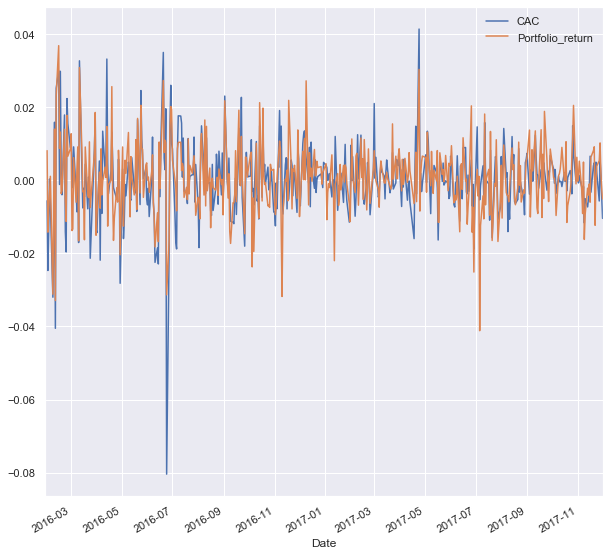

In [114]:
daily_retsnew[['CAC','Portfolio_return']].plot()


In [116]:
#we compute the mean of each return 
mean_retsnew = daily_retsnew.mean()
mean_retsnew

Oreal               0.000467
Sodexo              0.000569
Capgemini           0.000477
CAC                 0.000442
Portfolio_return    0.000525
dtype: float64

In [119]:
#we annualized the return 
Portfolionreturnannual =  mean_retsnew[4]* np.sqrt(252)
Cacannual = mean_retsnew[3]* np.sqrt(252)

print("CAC annual return : {}".format(Cacannual*100))
print("Portfolion annual return : {}".format(Portfolionreturnannual*100))

CAC annual return : 0.7011149441207837
Portfolion annual return : 0.8332349491553712


# Treynor Ratio

$$
T = \frac{R-R_{f}}{\beta}
$$

### The Capital Asset Pricing Model (CAPM)

The **CAPM** is in some sense an example of factor model. In particular, it is used to determine a theoretically appropriate return of an asset to make decisions about adding this asset 
to a well-diversified portfolio.

The model takes into account the asset's sensitivity to non-diversifiable risk (also known as systematic risk or market risk), often represented by the quantity beta (β) in the financial industry, as well as the expected return of the market and the expected return of a theoretical risk-free asset. 

The model can be used for pricing an individual security. The model defines a 
**Security Market Line (SML)** which enables us to compute the reward-to-risk ratio for a security in relation to that of the **overall market**:
$$
\text{SML}: \;\mathbb{E}[r_i] = \beta_i(\mathbb{E}[r_m] - r_f) + r_f, 
$$
which means that the **excess return** of the asset $i$ is given by the **excess return of the market** 
(here, **$r_m$ is the return of the market** and $r_f$ is the risk-free rate) 
times a coefficient $\beta_i$ defined as:
$$
\mathbb{E}[r_i] - r_f = \beta_i(\mathbb{E}[r_m] - r_f), 
\qquad  
\beta_i := \frac{\text{Cov}(r_i,r_m)}{\text{Var}(r_m)}, 
$$
which is the **sensitivity of the asset with respect to the market**.

Note that if $\beta_i$ is large, it means that the asset $i$ is higly correlated with the market, i.e., if the market goes up and so goes up the asset (and, of course, if the market goes down, then the asset goes down). On the other hand, if $\beta_i$ is very small, it means that the stock is almost uncorrelated with respect to the market, hence changes in the market do not affect the returns of the asset.

In [124]:
#we drop nan value
daily_retsnew.fillna(0)

,Oreal,Sodexo,Capgemini,CAC,Portfolio_return
Date,,,,,
2016-01-29,0.000000,0.000000,0.000000,0.000000,0.000000
2016-02-01,-0.000635,0.014751,0.011893,-0.005590,0.008147
2016-02-02,-0.006669,-0.019784,-0.019629,-0.024666,-0.014165
2016-02-03,-0.014706,-0.002676,-0.009711,-0.013312,-0.007863
2016-02-04,-0.000649,-0.005590,-0.008353,0.000371,-0.003487
...,...,...,...,...,...
2017-11-27,-0.007212,0.015059,-0.004933,-0.005634,0.005422
2017-11-28,0.006726,0.012981,0.004462,0.005670,0.010260
2017-11-29,-0.000802,0.004119,-0.038500,0.001404,0.001805


In [126]:
#we compute the regression by the OLS method 
# the OLS methods assume a bias equal to 0, hence a specific variable for the bias has to be given 
import statsmodels.api as smt
lm = smt.OLS(daily_retsnew['Portfolio_return'].fillna(0), daily_retsnew['CAC'].fillna(0)).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       Portfolio_return   R-squared (uncentered):                   0.504
Model:                            OLS   Adj. R-squared (uncentered):              0.503
Method:                 Least Squares   F-statistic:                              482.6
Date:                Mon, 02 Mar 2020   Prob (F-statistic):                    2.74e-74
Time:                        15:35:11   Log-Likelihood:                          1709.4
No. Observations:                 475   AIC:                                     -3417.
Df Residuals:                     474   BIC:                                     -3413.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
CAC            0.6674      0.030     21.968      0.000       0.608       0.727
==============================================================================
Omnibus:                       64.453   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              290.699
Skew:                          -0.489   Prob(JB):                     7.51e-64
Kurtosis:                       6.706   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [127]:
#we get that the beta is 0.66 
lm.params

CAC    0.667381
dtype: float64

In [131]:
Treynor_ratio = Portfolionreturnannual/0.66
Treynor_ratio*100

1.2624771956899563

# Risk Analysis


### Value at Risk (VaR)

It represents the **maximum expected loss** over a certain time period. 
First of all, we specify a certain confidence **level**, in $(0,1)$, although it is typically expressed in percentage. 

For example consider a $99\%$ level (i.e., $\alpha=0.99$). When we say **$99\%$ monthly VaR** it means that we are looking at the **worst possibile outcome over a month after excluding the $1\%$ of extreme worst losses**. In other words, what is **the maximum loss that you can take with $99\%$ of probability  over one month**.

**Example:** we are given the following set of monthly returns:
$$
R = (-4\%, +5\%, +2\%, -7\%, +1\%, +0.5\%, -2\%, -1\%, -2\%, +5\%).
$$
**What is the $90\%$ monthly VaR?** 

So what we have to do is 1) to exclude the $10\%$ worst returns and 2) looking at the worst return of the remaining ones. 
Since we have $10$ returns, the $10\%$ worse return is just $1$ return, i.e., $-7\%$, and so the worse return of the remaing ones is $-4\%$. 
Then $\text{VaR} = 4\%$.

**NOTE THAT although the value we find was $-4\%$ we say that $\text{VaR} = 4\%$, i.e., the VaR is tipically a positive number.**


Mathematically, the VaR is defined as follow. Given the confidence level $\alpha\in(0,1)$,
$$
\text{VaR}_{\alpha}
:= - \text{inf}\{x\in\mathbb{R} \;:\; \mathbb{P}(R \leq x) \geq 1-\alpha \} 
= - \text{inf}\left\{x\in\mathbb{R} \;:\;  \mathbb{P}(R \geq x) \leq \alpha\right\},  
$$
that is, it is nothing but that the **$(1-\alpha)$-quantile** since we effectively want to find the number $\text{VaR}_\alpha$ such that 
$$
\mathbb{P}( R \leq -\text{VaR}_\alpha) = 1-\alpha,
$$
which says that there is a $(1-\alpha)\%$ probability of having a (negative) return greater or equal to $-\text{VaR}_\alpha$.

In previous example, the $90\%$ monthly VaR equal to $4\%$, means that 
$$
0.04 = \text{VaR}_{0.9} = -\text{inf}\{x\in\mathbb{R} \;:\; \mathbb{P}(R \leq x) \geq 0.01 \},
$$
i.e., there is a $10\%$ probability of loosing more than $4\%$ of our money invested (having monthly returns less than -$4\%$). 

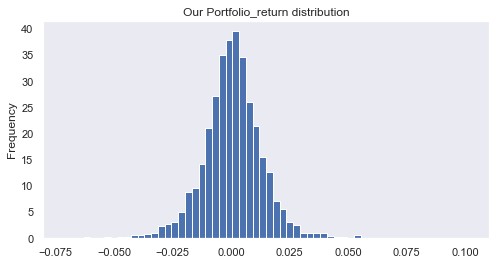

In [132]:
# get the portfolio returns before the holding periode 
daily_rets['Portfolio_return'] = optimal_weights[4]*daily_rets['Oreal'] + optimal_weights[8]*daily_rets['Sodexo'] + optimal_weights[10]*daily_rets['Capgemini']

# ...and plot their distribution
ax = daily_rets['Portfolio_return'].plot.hist(figsize=(8,4), bins=60, density=True)
ax.set_title("Our Portfolio_return distribution")
ax.grid()

We want to get the $90\%$, $95\%$, and $99\%$ monthly VaR. 
That is, we have levels $1-\alpha=0.01, 0.05, 0.01$. We can use the *percentile* method.

In [137]:
alpha = np.array([0.90, 0.95, 0.99])
level = 1 - alpha

# In the percentile method, we multiply by 100 because it wants an input between 0 and 100
VaRs = -np.percentile(daily_rets['Portfolio_return'].fillna(0), level*100)

print("90% Var: {:.2f}%".format(VaRs[0] * 100))
print("95% Var: {:.2f}%".format(VaRs[1] * 100))
print("99% Var: {:.2f}%".format(VaRs[2] * 100))

90% Var: 1.45%
95% Var: 2.00%
99% Var: 3.51%


# Author: 
Audric Dongfack Kengfack 